In [1]:
from typing import Optional
import argparse
import os
import sys

import torch
import matplotlib.pyplot as plt     # type: ignore

import utilities
import model
import optimize
import pandas as pd

from utils import default_paths

import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

info_fn = os.path.join(default_paths.stim_root, 'Indep_set_info.csv')
print('\nloading image info from %s\n'%info_fn)
info_df = pd.read_csv(info_fn, index_col=0)


cuda

loading image info from /user_data/mmhender/nsd/stimuli/Indep_set_info.csv



In [127]:
class net(torch.nn.Module):
    
    def __init__(self, device):
        
        super().__init__()
    
        self.device = device
        self.n_chunks = 5;
        self.n_convs_per_chunk = [2, 2, 4, 4, 4]
        
        self._get_layer_names()
        self.n_layers = len(self.layer_names)
        
        self._get_modules()
        
        self.init_activs()
        
        
    def init_activs(self):
        
        self.activs = [[] for ll in range(self.n_layers)]
    
    def _get_layer_names(self):
        
        names = []
        conv_counter = 0;
        for ch in range(self.n_chunks):
            for cv in range(self.n_convs_per_chunk[ch]):   
                conv_counter+=1  
                names+= ['Conv%d'%conv_counter]
                # names+= ['ReLU%d'%conv_counter]   
            names+= ['MaxPool%d'%(ch+1)]

        self.layer_names = names
        
    def _get_modules(self):
        
        modules = []
        conv_counter = -1;
        in_channels_conv = [3, 64,64, 128,128, 256,256,256,256, 512,512,512,512,512,512,512]
        out_channels_conv = [64, 64,128, 128,256, 256,256,256,512, 512,512,512,512,512,512,512]
        for ch in range(self.n_chunks):
            for cv in range(self.n_convs_per_chunk[ch]):   
                conv_counter+=1  
                mod = torch.nn.Conv2d(in_channels = in_channels_conv[conv_counter],
                                          out_channels = out_channels_conv[conv_counter], 
                                          kernel_size=(3,3), stride=(1,1), padding=(1,1), 
                                          bias = False)
                mod.weight.data.fill_(1.0)
                modules.append(mod.to(self.device))
            # mod = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
            mod = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            modules.append(mod.to(self.device))
            
        self.modules = modules
        
    def forward(self, image_batch):
        
        current = image_batch
        
        for ii, mod in enumerate(self.modules):
            
            a = mod(current)
            clamp_min = torch.Tensor([0.0]).to(self.device)
            clamp_max = torch.Tensor([1.0]).to(self.device)
            a = torch.minimum(torch.maximum(a, clamp_min), clamp_max)
            self.activs[ii] = a.detach().cpu().numpy()
            
            current = a
            
        return current

In [128]:
model = net(device)

In [129]:
n_pix = 256
pixel_centers_x, pixel_centers_y = np.meshgrid(np.arange(n_pix), np.arange(n_pix))
pixel_centers = list(zip(np.ravel(pixel_centers_y), np.ravel(pixel_centers_x)))


vgg19_layer_names = model.layer_names

layer_names_use = vgg19_layer_names
layer_inds = [np.where([n==name for n in vgg19_layer_names])[0][0] \
                                              for name in layer_names_use]

template_batch = torch.Tensor(np.zeros((1,3,n_pix, n_pix))).to(device)
out = model(template_batch)
activs = model.activs
res_each_layer = [aa.shape[2] for aa in activs]
model.init_activs()

spatunits_each_layer = [res**2 for res in res_each_layer]

n_total_pix = n_pix**2

layer_unit_centers = []
for n_units in res_each_layer:

    unit_centers_x, unit_centers_y = np.meshgrid(np.arange(n_units), np.arange(n_units)) 
    centers = list(zip(unit_centers_y.ravel(), unit_centers_x.ravel())) 
    layer_unit_centers.append(centers)
    
   

In [183]:
(3,3)==(3,3)

True

In [184]:
tuple(centers_do[0])

(64, 64)

In [202]:
centers_do = [[64, 64], 
              [64, 191],
              [191, 64],
              [191, 191],
              [127,127],
              [127,128],
              [128,127],
              [128,128],
              [0,0], 
              [0,255],
              [255,0],
              [255,255]
             ]

pixels_do = [ np.where([pp==tuple(centers_do[cc]) for pp in pixel_centers])[0][0]
                 for cc in range(len(centers_do))]

In [203]:
pixels_do

[16448, 16575, 48960, 49087, 32639, 32640, 32895, 32896, 0, 255, 65280, 65535]

In [204]:
import time

batch_size=1;

n_batches = int(np.ceil(n_total_pix/batch_size))

rfs_each_layer = [np.zeros([n_total_pix, n], dtype=bool) for n in spatunits_each_layer]

for bb in pixels_do:
# for bb in range(n_batches):

    if np.mod(bb,100)==0:
        print('processing pixel batch %d of %d'%(bb, n_batches))

    pixels_batch = np.arange(bb*batch_size, np.minimum((bb+1)*batch_size, n_total_pix))
    
    st = time.time()
    image_batch = torch.Tensor(np.zeros((len(pixels_batch),3,n_pix, n_pix))).to(device)                  
    for ii, pix in enumerate(pixels_batch):
        center = pixel_centers[pix]
        # print(center)
        image_batch[ii,:,center[0], center[1]] = 1.0
        
    elapsed = time.time() - st;
    # print('took %.5f s to make one-hot ims'%elapsed)
    
    st = time.time()
    with torch.no_grad():
        
        out = model(image_batch)
        activs = model.activs
        model.init_activs()
        
    elapsed = time.time() - st;
    # print('took %.5f s to get activs'%elapsed)
    
    st = time.time()
    for ll, act in enumerate(activs):
        
        # a = np.sum(act[:,:,:,:], axis=1)>0
        a = act[:,0,:,:]>0
        
        rfs_each_layer[ll][pixels_batch,:] = np.reshape(a, [len(pixels_batch), -1])
        
    elapsed = time.time() - st;
    # print('took %.5f s to make rfs'%elapsed)
    

processing pixel batch 0 of 65536


In [209]:
rfs_each_layer[20].shape

(65536, 64)

In [205]:
pixels_do

[16448, 16575, 48960, 49087, 32639, 32640, 32895, 32896, 0, 255, 65280, 65535]

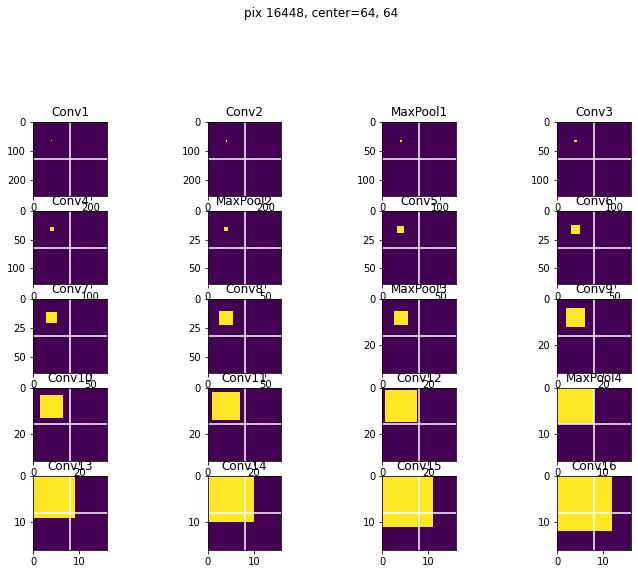

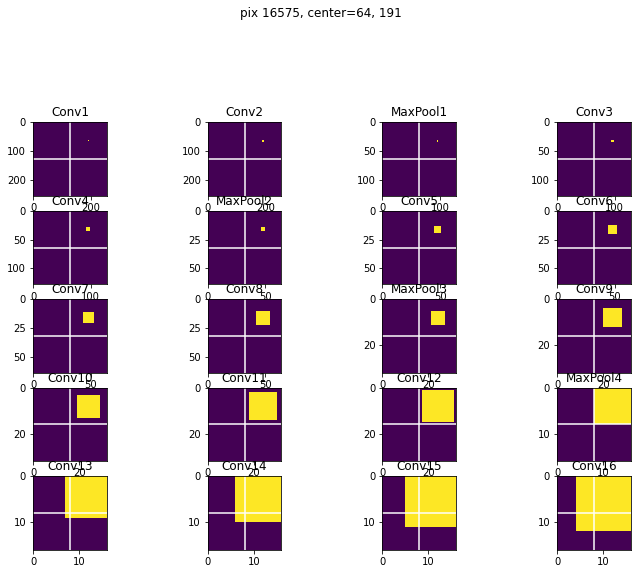

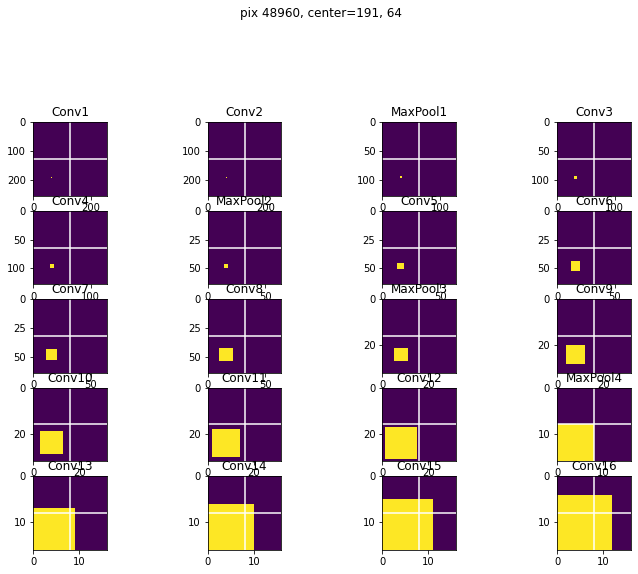

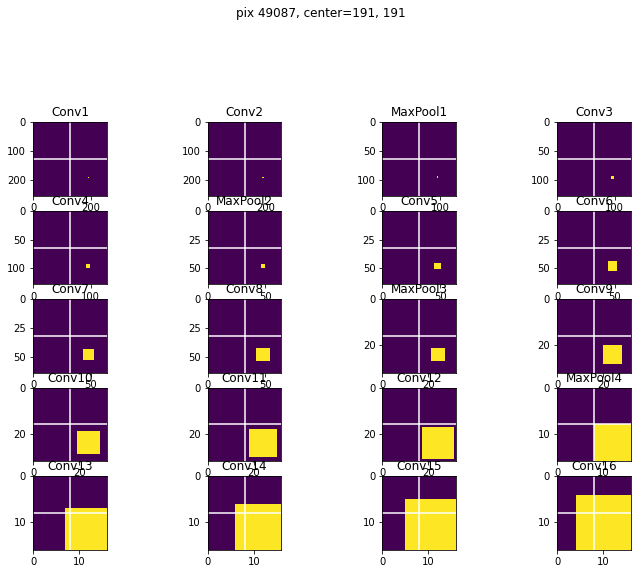

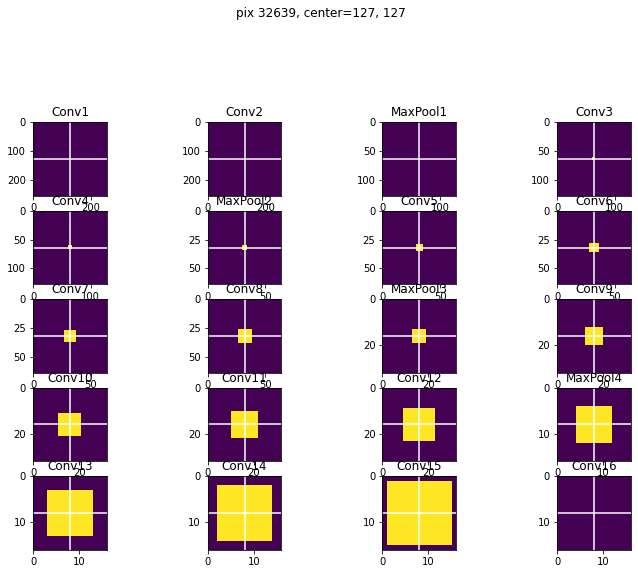

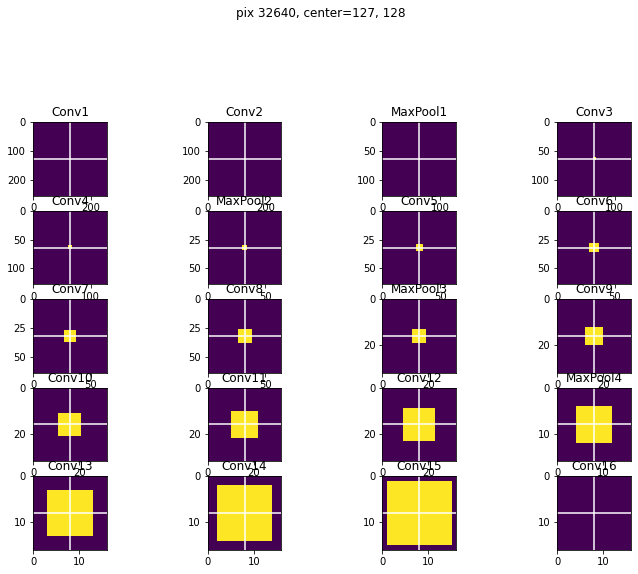

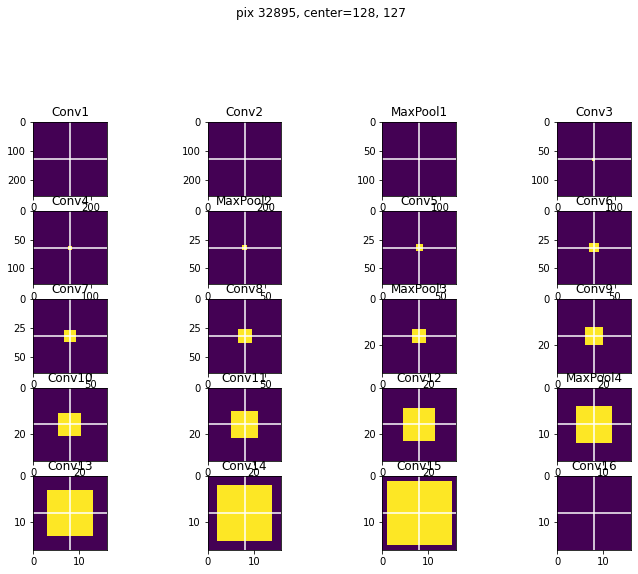

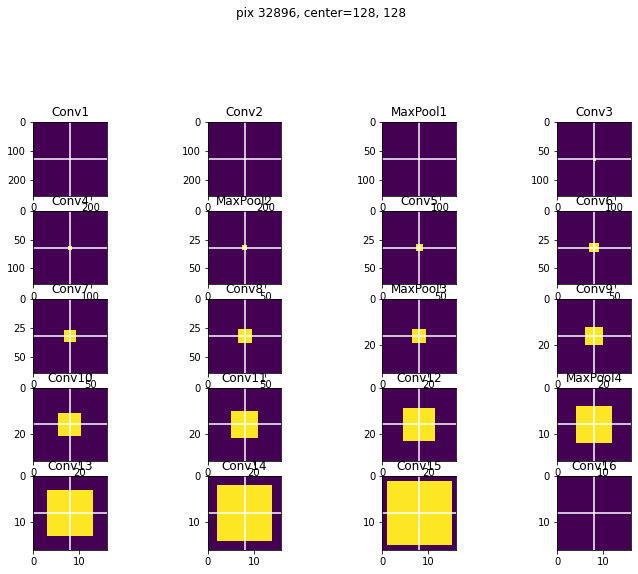

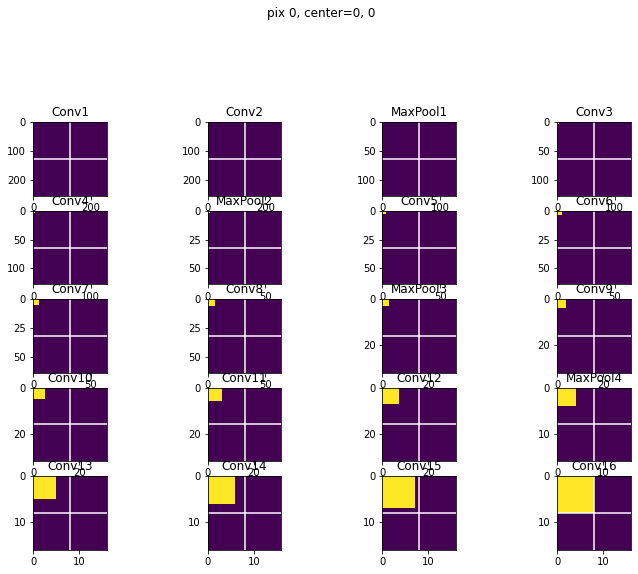

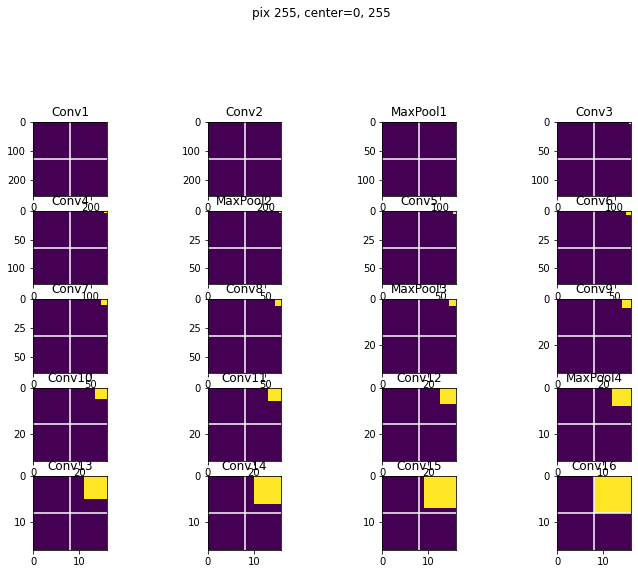

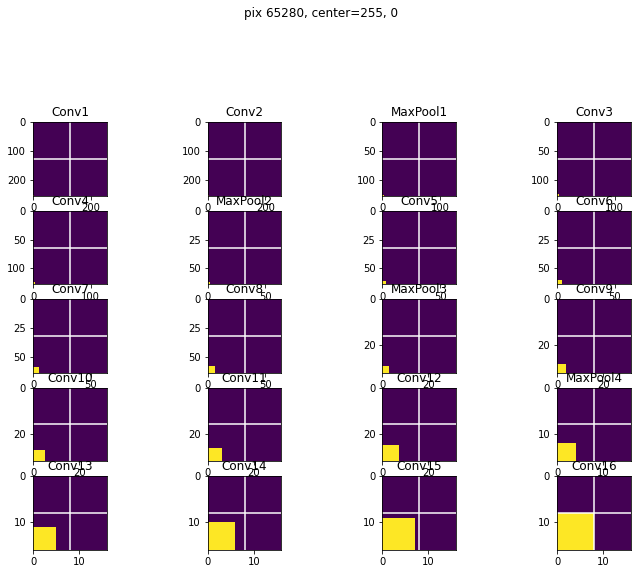

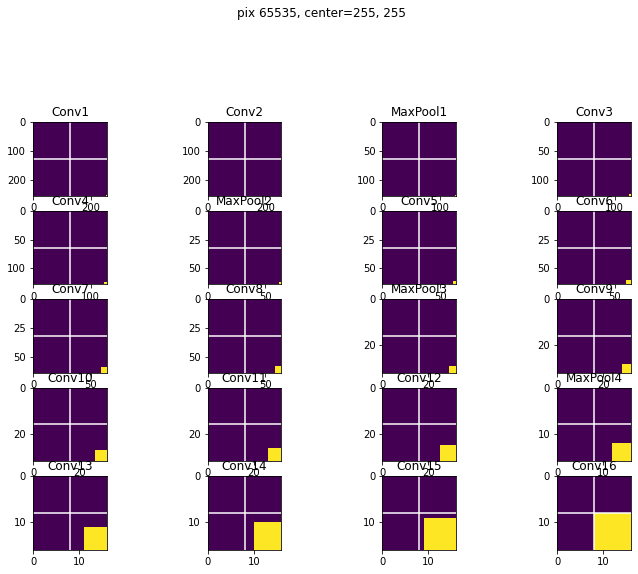

In [206]:

pix_inds = pixels_do

for pix_ind in pix_inds:

    plt.figure(figsize=(12,16));

    pi=0
    for ll in range(len(layer_names_use)-1):

        rf = rfs_each_layer[ll][pix_ind,:]
        res = res_each_layer[ll]
        rf = np.reshape(rf, [res, res])

        pi+=1
        plt.subplot(10,4,pi)
        plt.pcolormesh(rf)
        plt.axis('square')
        plt.gca().invert_yaxis()
        plt.axhline(res/2, color='w')
        plt.axvline(res/2, color='w')
        plt.title(layer_names_use[ll])
        
    plt.suptitle('pix %d, center=%d, %d'%(pix_ind, pixel_centers[pix_ind][0], pixel_centers[pix_ind][1])) 

9
49
100
100


Text(0.5, 0.98, 'pix 32640, center=127, 128')

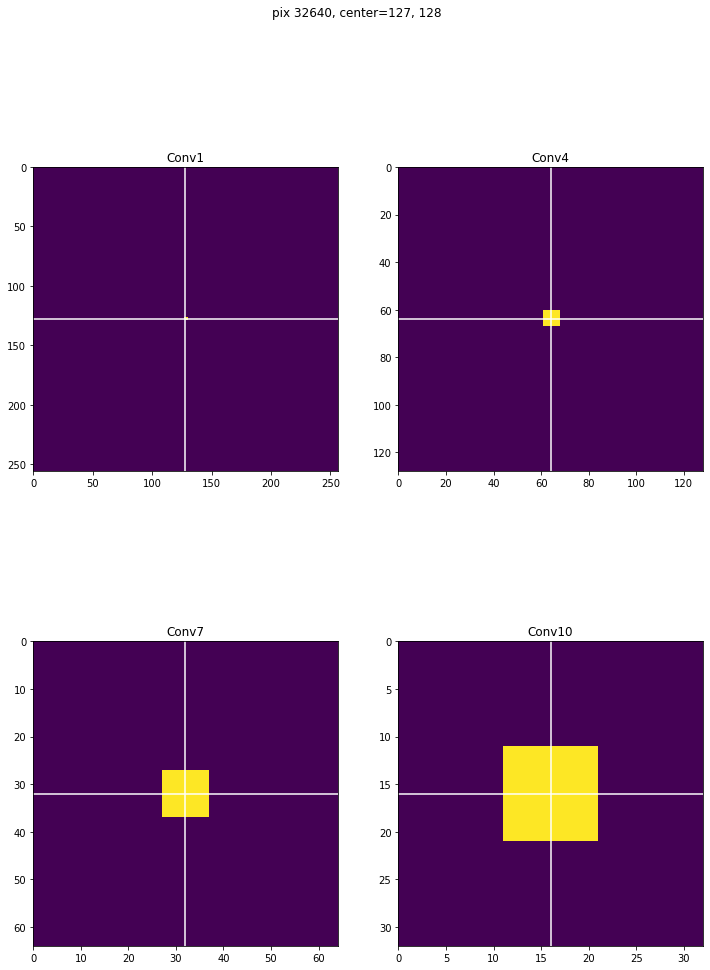

In [191]:

pix_ind = pixels_do[5]
# pix_inds = pixels_do

# for pix_ind in pix_inds:

plt.figure(figsize=(12,16));

pi=0
for ll in [0, 4, 8, 12]:
# for ll in range(len(layer_names_use)-1):

    rf = rfs_each_layer[ll][pix_ind,:]
    res = res_each_layer[ll]
    rf = np.reshape(rf, [res, res])

    print(np.sum(rf))
    
    pi+=1
    plt.subplot(2,2,pi)
    plt.pcolormesh(rf)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.axhline(res/2, color='w')
    plt.axvline(res/2, color='w')
    plt.title(layer_names_use[ll])

plt.suptitle('pix %d, center=%d, %d'%(pix_ind, pixel_centers[pix_ind][0], pixel_centers[pix_ind][1])) 